In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import finnhub
import matplotlib.dates as mpl_dates
import numpy as np
from datetime import * 
import seaborn as sns

In [165]:
def get_RS(ticker, start, end):
    
    # Setup client
    finnhub_client = finnhub.Client(api_key = "bt3efpf48v6tfcs816eg")
    
    start = list(start)
    end = list(end)
    # Stock candles
    start_time = int(datetime(start[0], start[1], start[2], 0, 0).replace(tzinfo = timezone.utc).timestamp())
    end_time = int(datetime(end[0], end[1], end[2], 0, 0).replace(tzinfo = timezone.utc).timestamp())
    res = finnhub_client.stock_candles(ticker, 'D', start_time, end_time)

    stock = pd.DataFrame(res)
    stock = stock.rename(columns = {'t':'Date', 'o':'Open', 'h':'High', 'l':'Low', 'c':'Close', 's':'status', 'v':'volumn'})
    stock['Date'] = pd.to_datetime(stock['Date'], unit = 's')
    stock = stock.set_index('Date')
    
    def get_optimum_clusters(df, saturation_point = 0.05):
        
        '''
        :param df: dataframe
        :param saturation_point: The amount of difference we are willing to detect
        :return: clusters with optimum K centers
        This method uses elbow method to find the optimum number of K clusters
        We initialize different K-means with 1..10 centers and compare the inertias
        If the difference is no more than saturation_point, we choose that as K and move on
        '''

        wcss = []
        k_models = []
        labels = []
        
        days = df.shape[0]

        size = min(int(8 * ((days/21)**0.48)), days)
        for i in range(1, size):
            # kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            kmeans = KMeans(n_clusters = i, init='random', max_iter=300, n_init=10)
            kmeans.fit(df)
            wcss.append(kmeans.inertia_) # Sum of squared distances of samples to their Closest cluster center
            k_models.append(kmeans)
            labels.append(kmeans.labels_)
        # Compare differences in inertias until it's no more than saturation_point
        optimum_k = len(wcss)-1
        for i in range(0, len(wcss)-1):
            diff = abs(wcss[i+1] - wcss[i])
            if diff < saturation_point:
                optimum_k = i
                break
        # optimum_clusters = k_models[optimum_k]
        labels = labels[optimum_k]

        return labels
    
    # resitances and supports
    Lows = pd.DataFrame(data = stock, index = stock.index, columns = ['Low'])
    Highs = pd.DataFrame(data = stock, index = stock.index, columns = ['High'])
    low_labels = get_optimum_clusters(Lows)
    high_labels = get_optimum_clusters(Highs)
    Lows['labels'] = pd.Series(low_labels, index = Lows.index)
    Highs['labels'] = pd.Series(high_labels, index = Highs.index)
    res = [max(Highs.loc[Highs.labels == i, 'High']) for i in np.unique(high_labels)]
    sup = [min(Lows.loc[Lows.labels == i, 'Low']) for i in np.unique(low_labels)]
    
    # pivotpoints
    last_day = stock.iloc[-1].to_frame().T
    not_pivots = list(last_day.columns)
    last_day['Pivot'] = (last_day['High'] + last_day['Low'] + last_day['Close'])/3
    last_day['R1'] = 2*last_day['Pivot'] - last_day['Low']
    last_day['S1'] = 2*last_day['Pivot'] - last_day['High']
    last_day['R2'] = last_day['Pivot'] + (last_day['High'] - last_day['Low'])
    last_day['S2'] = last_day['Pivot'] - (last_day['High'] - last_day['Low'])
    last_day['R3'] = last_day['Pivot'] + 2*(last_day['High'] - last_day['Low'])
    last_day['S3'] = last_day['Pivot'] - 2*(last_day['High'] - last_day['Low'])
    pivots = [n for n in last_day.columns if n not in not_pivots]
    pcols = ['green', 'blue', 'blue', 'red', 'red', 'black', 'black']
    
    # plot params setting
    
    plt.rcParams['figure.figsize'] = [12, 7]
    plt.rc('font', size = 14)
    
    n = stock.shape[0] # number of days
    
    xlim_min = 3 * (n/21)
    xlim_max = 6 * (n/21) * 1.2
    rs_length = 1 * (n/21)
    rs_text_x = 0.8 * (n/21) * 1.2
    rs_text_y_res = 0.1 * ((n/21)**0.5)
    rs_text_y_sup = 0.5 * ((n/21)**0.5)
    font_size = 10
    
    pivot_xmin = 1 * (n/21)
    pivot_xmax = 2 * (n/21)
    pivot_text_x = 2.2 * (n/21)
    pivot_text_y = 0.15 * ((n/21)**0.05)

    # plot
    sns.set_theme()
    # plt.rcParams['figure.figsize'] = [12, 7]
    # plt.rc('font', size = 14)
    fig, ax = plt.subplots()

    stock['Date'] = pd.to_datetime(stock.index)
    stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
    stock = stock.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

    ax.set_xlim([stock.Date[0] - xlim_min, stock.Date[-1] + xlim_max])

    candlestick_ohlc(ax, stock.values, width = 0.6,\
                     colorup = 'green', colordown = 'red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.tight_layout()

    Highs['Date'] = pd.to_datetime(Highs.index)
    Highs['Date'] = Highs['Date'].apply(mpl_dates.date2num)
    min_date_high = min(Highs.Date)
    max_date_high = max(Highs.Date)
    for i in range(len(res)):
        mu = Highs[Highs.High == res[i]].Date.values[0]
        plt.hlines(res[i], xmin = mu - rs_length,\
                   xmax = min(mu + rs_length, max_date_high),\
                   color = 'red', linewidth = 3)
        plt.text(x = mu - rs_text_x, y = res[i] + rs_text_y_res,\
                 s = str(res[i]), size = font_size)

    Lows['Date'] = pd.to_datetime(Lows.index)
    Lows['Date'] = Lows['Date'].apply(mpl_dates.date2num)
    min_date_low = min(Lows.Date)
    max_date_low = max(Lows.Date)
    for i in range(len(sup)):
        mu = Lows[Lows.Low == sup[i]].Date.values[0]
        plt.hlines(sup[i], xmin = max(min_date_low, mu - rs_length),\
                   xmax = min(mu + rs_length, max_date_low),\
                   color = 'green', linewidth = 3)
        plt.text(x = mu - rs_text_x, y = sup[i] - rs_text_y_sup,\
                 s = str(sup[i]), size = font_size)

    for i, col in enumerate(pivots):
        plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + pivot_xmin,\
                   xmax = stock.Date[-1] + pivot_xmax,\
                   color = pcols[i], linewidth = 2)
        plt.text(x = stock.Date[-1] + pivot_text_x, y = last_day[col].iloc[-1] - pivot_text_y,\
                 s = col + ': ' + str(round(last_day[col].iloc[-1], 3)),\
                 color = pcols[i], size = font_size/((n/21)**0.01))

    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    plt.title('Supports and Resistances Using K-mean Clustering')
    plt.show()

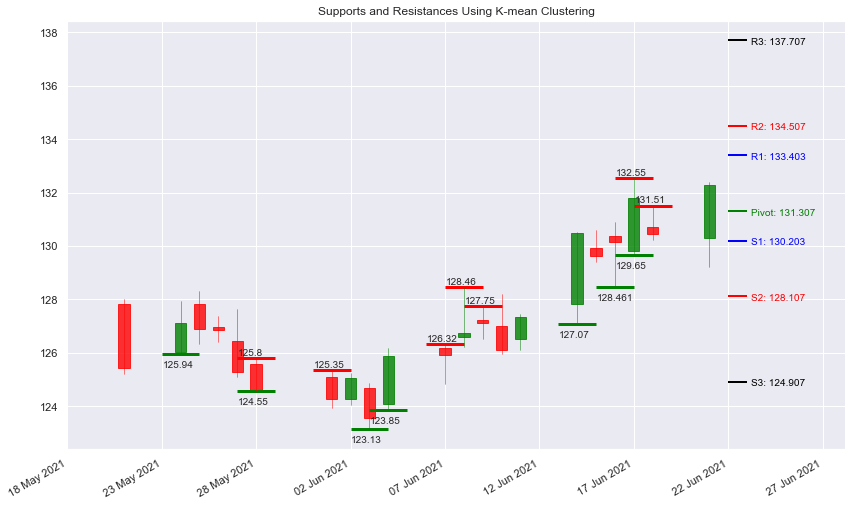

In [167]:
get_RS(ticker = 'AAPL', start = (2021, 5, 21), end = (2021, 6, 21))